This notebook showcases the yfinance timeseries feature as well as the BollingerBand anomaly detection features in news-signals library added in v0.8.0.

Lets get necessary non news-signals imports for this notebook

In [2]:
import copy
import requests
import json
import datetime
import matplotlib.pyplot as plt

Lets import the needed news-signals features. 

Put your NewsAPI Key and ID in **NEWSAPI_APP_KEY** and **NEWSAPI_APP_ID**. 

Although it is not necessary and you can comment out building a pre-existing news-volume signal and just get the finance timeseries further down in the notebook.

In [ ]:
from news_signals import signals
NEWSAPI_APP_KEY= ""
NEWSAPI_APP_ID= ""
from news_signals import signals, newsapi, wikidata_utils
newsapi.set_headers(NEWSAPI_APP_ID, NEWSAPI_APP_KEY)
from news_signals.anomaly_detection import SigmaAnomalyDetector, BollingerAnomalyDetector

In [4]:
# utility function for getting a wikidata id from an entity name

WIKIDATA_SEARCH_URL = "https://www.wikidata.org/w/api.php"
DEFAULT_SEARCH_PARAMS = {
    "action": "wbsearchentities",
    "format": "json",
    "errorformat": "plaintext",
    "language": "en",
    "uselang": "en",
    "type": "item",
    "limit": 1
}
WD_ENTITY_BASE_URL = 'https://www.wikidata.org/wiki/Special:EntityData'
    

def search_wikidata(surface_form, min_length=3):
    params = copy.deepcopy(DEFAULT_SEARCH_PARAMS)
    params["search"] = surface_form
    result = []
    try:
        print(f'querying wikidata with params: {params}')
        r = requests.get(url=WIKIDATA_SEARCH_URL, params=params)
        data = json.loads(r.text)
        if 'search' in data:
            result = data['search']
            result = result[0:min(100, len(result))]
    except Exception as e:
        print(f'Error searching wikidata for surface form: {surface_form}')
        print(e)
    return result

This is setting up to get the news volume signals. 

Feel free to modify **entity_name** !

In [5]:
# let's setup the entity we want to work with

entity_name = 'Twitter'

entity_id_candidates = search_wikidata(entity_name)
test_entity = entity_id_candidates[0]

querying wikidata with params: {'action': 'wbsearchentities', 'format': 'json', 'errorformat': 'plaintext', 'language': 'en', 'uselang': 'en', 'type': 'item', 'limit': 1, 'search': 'Twitter'}


Here we instantiate the AylienSignal class. 

If you do not have an NewsAPI key, you can blank instantiate the class and just add the yfinance timeseries later on.

In [6]:

signal = signals.AylienSignal(
    name=test_entity['label'],
    params={"entity_ids": [test_entity['id']]}
)

Here we define the start to end dates for the news volume timeseries and get the signal. Feel free to modify this too !

In [7]:
start = '2023-01-01'
end = '2024-02-21'

timeseries_signal = signal(start, end)

Now we can plot our news volume timeseries

<Axes: xlabel='date'>

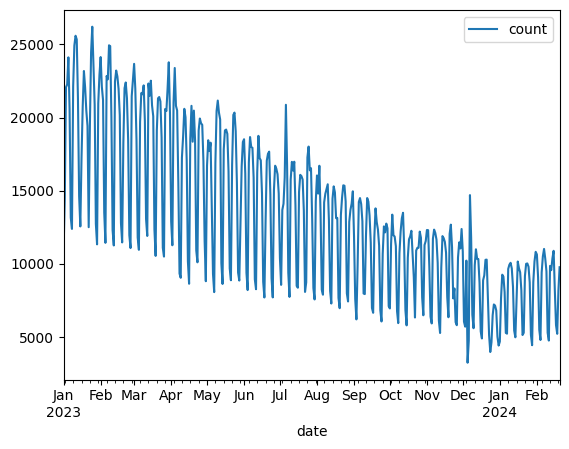

In [8]:
signal.plot()

Now we can finally add our yfinance market timeseries.

About the function:

The date range is determined from self.start and self.end (if available),
or from the minimum and maximum dates of self.timeseries_df's index.

Parameters:
- ticker (str): The stock ticker symbol to retrieve (required).
- columns (str or list of str, optional): The column(s) to extract from the yfinance data.
    Defaults to ["Close"]. If "RSI" is included, RSI data will be retrieved. 
    
    Has Columns **["Open","Close","Volume","High","Low","RSI"]**
- overwrite_existing (bool): Whether to overwrite existing yfinance data if already present.
- append_dates (bool):
    If True, any dates present in the yfinance data that are not already in self.timeseries_df
    will be appended (the DataFrame is reindexed to the union of dates).
    If False, only rows with dates common to both DataFrames are updated.

Returns:
- self: The signal instance with the new timeseries data.

In [9]:
timeseries_signal.add_yfinance_timeseries(
    ticker="AAPL",
    columns=["Open","Close","Volume","High","Low","RSI"],
)

print(timeseries_signal.timeseries_df)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

                           count          published_at        open  \
date                                                                 
2023-01-01 00:00:00+00:00  10968  2023-01-01T00:00:00Z         NaN   
2023-01-02 00:00:00+00:00  14491  2023-01-02T00:00:00Z         NaN   
2023-01-03 00:00:00+00:00  22070  2023-01-03T00:00:00Z  128.782641   
2023-01-04 00:00:00+00:00  22266  2023-01-04T00:00:00Z  125.431615   
2023-01-05 00:00:00+00:00  24115  2023-01-05T00:00:00Z  125.668849   
...                          ...                   ...         ...   
2024-02-16 00:00:00+00:00   8218  2024-02-16T00:00:00Z  182.558001   
2024-02-17 00:00:00+00:00   5812  2024-02-17T00:00:00Z         NaN   
2024-02-18 00:00:00+00:00   5217  2024-02-18T00:00:00Z         NaN   
2024-02-19 00:00:00+00:00   8146  2024-02-19T00:00:00Z         NaN   
2024-02-20 00:00:00+00:00   9769  2024-02-20T00:00:00Z         NaN   

                                close       volume        high         low  \
date       

Now finally, lets do Bollinger Band Anomaly Detection on our retrived yfinance data.

Explanation of Parameters

**window**:The window parameter specifies the size of the rolling window used to calculate the moving average and standard deviation. For example, if window=20, the moving average and standard deviation are calculated over the past 20 data points.

**num_std**: The num_std parameter specifies the number of standard deviations to use for the upper and lower Bollinger Bands. For example, if num_std=2.0, the upper band is calculated as the moving average plus two times the standard deviation, and the lower band is calculated as the moving average minus two times the standard deviation.

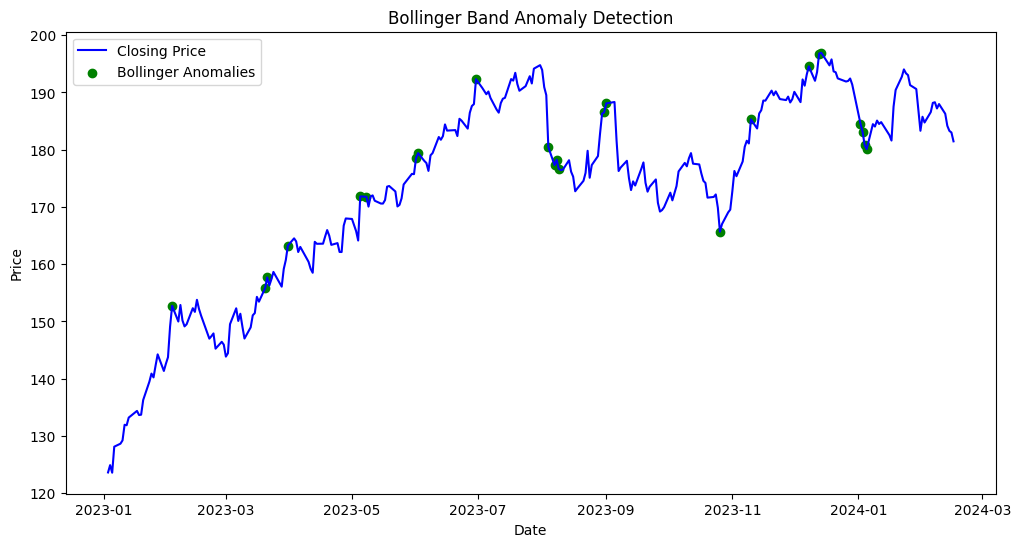

In [10]:
# Drop unnecessary columns
filtered_df = timeseries_signal.timeseries_df.drop(columns=["count", "published_at"])

# Drop rows where 'open' and 'close' are NaN
filtered_df = filtered_df.dropna(subset=["open", "close"])

# Initialize Bollinger anomaly detector
bollinger_detector = BollingerAnomalyDetector(window=20, num_std=2.0)

# Apply Bollinger Anomaly Detection on 'close' prices
bollinger_anomalies = bollinger_detector(history=filtered_df["close"], series=filtered_df["close"])

# Create a single plot for Bollinger anomalies
plt.figure(figsize=(12, 6))

# Plot closing prices
plt.plot(filtered_df.index, filtered_df["close"], label="Closing Price", color="blue")

# Identify and plot anomalies
bollinger_anomalies = bollinger_anomalies.reindex(filtered_df.index)
anomaly_points = filtered_df["close"][bollinger_anomalies > 0]

plt.scatter(anomaly_points.index, anomaly_points, color="green", label="Bollinger Anomalies", marker="o")

# Labels and legend
plt.title("Bollinger Band Anomaly Detection")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()

plt.show()
